# Ensemble Strategies for Anomaly Detection: A Complete Python Guide

The power of many outperforms the wisdom of one. In anomaly detection, combining multiple algorithms often yields superior results compared to any single method. This comprehensive guide explores ensemble strategies that leverage the strengths of different detectors to catch anomalies more effectively.

## What are Ensemble Methods?

Ensemble methods combine predictions from multiple models to create a more robust and accurate detector. Just as a panel of experts is better than one specialist, ensemble approaches:

- **Reduce false positives** by requiring agreement from multiple detectors
- **Improve recall** by capturing anomalies missed by individual methods
- **Increase robustness** across different anomaly types
- **Provide confidence scores** based on consensus

### Why Ensemble for Anomaly Detection?

Different algorithms excel at detecting different types of anomalies:
- **Isolation Forest**: Global outliers and random anomalies
- **LOF**: Local density anomalies
- **One-Class SVM**: Boundary violations
- **DBSCAN**: Cluster-based outliers
- **Statistical methods**: Distribution deviations

Combining them catches more anomalies while reducing false alarms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy import stats

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
np.random.seed(42)

# Normal data: multiple clusters
np.random.seed(42)
n_samples = 1000
n_outliers = 50

# Normal patterns
cluster1 = np.random.normal(loc=[0, 0], scale=0.5, size=(300, 2))
cluster2 = np.random.normal(loc=[5, 5], scale=0.6, size=(300, 2))
cluster3 = np.random.normal(loc=[0, 5], scale=0.4, size=(300, 2))
cluster4 = np.random.normal(loc=[5, 0], scale=0.5, size=(100, 2))

X_normal = np.vstack([cluster1, cluster2, cluster3, cluster4])

# Different types of outliers
global_outliers = np.random.uniform(-3, 8, (20, 2))  # Random scattered
local_outliers = np.array([[2.5, 2.5], [2.6, 2.4], [2.4, 2.6]])  # Between clusters
local_outliers = local_outliers + np.random.normal(0, 0.1, local_outliers.shape)
extreme_outliers = np.array([[-5, -5], [10, 10], [-5, 10], [10, -5]])  # Far corners
dense_outlier_cluster = np.random.normal(loc=[7.5, 2.5], scale=0.2, size=(23, 2))

X_outliers = np.vstack([global_outliers, local_outliers, extreme_outliers, dense_outlier_cluster])

# Combine all data
X = np.vstack([X_normal, X_outliers])
y_true = np.array([0] * len(X_normal) + [1] * len(X_outliers))

print(f"Total samples: {len(X)}")
print(f"Normal samples: {sum(y_true == 0)}")
print(f"Anomalies: {sum(y_true == 1)}")
print(f"Anomaly rate: {sum(y_true == 1) / len(y_true):.2%}")

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Total samples: 1050
Normal samples: 1000
Anomalies: 50
Anomaly rate: 4.76%


## Individual Detector Implementation

### 1. Isolation Forest

In [2]:
iso_forest = IsolationForest(
    contamination=0.05,  # Expected outlier proportion
    random_state=42,
    n_estimators=100
)

iso_predictions = iso_forest.fit_predict(X_scaled)
iso_scores = -iso_forest.score_samples(X_scaled)  # Negative for anomaly scores
iso_predictions = np.where(iso_predictions == -1, 1, 0)  # Convert to 0/1

print("Isolation Forest Results:")
print(f"Detected anomalies: {sum(iso_predictions)}")
print(f"Precision: {np.sum((iso_predictions == 1) & (y_true == 1)) / sum(iso_predictions):.3f}")
print(f"Recall: {np.sum((iso_predictions == 1) & (y_true == 1)) / sum(y_true):.3f}")

Isolation Forest Results:
Detected anomalies: 53
Precision: 0.792
Recall: 0.840


### 2. Local Outlier Factor (LOF)


In [3]:
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05,
    novelty=False
)

lof_predictions = lof.fit_predict(X_scaled)
lof_scores = -lof.negative_outlier_factor_
lof_predictions = np.where(lof_predictions == -1, 1, 0)

print("\nLocal Outlier Factor Results:")
print(f"Detected anomalies: {sum(lof_predictions)}")
print(f"Precision: {np.sum((lof_predictions == 1) & (y_true == 1)) / sum(lof_predictions):.3f}")
print(f"Recall: {np.sum((lof_predictions == 1) & (y_true == 1)) / sum(y_true):.3f}")


Local Outlier Factor Results:
Detected anomalies: 53
Precision: 0.453
Recall: 0.480


### 3. One-Class SVM


In [4]:
ocsvm = OneClassSVM(
    kernel='rbf',
    gamma='auto',
    nu=0.05  # Upper bound on fraction of outliers
)

ocsvm_predictions = ocsvm.fit_predict(X_scaled)
ocsvm_scores = -ocsvm.decision_function(X_scaled)
ocsvm_predictions = np.where(ocsvm_predictions == -1, 1, 0)

print("\nOne-Class SVM Results:")
print(f"Detected anomalies: {sum(ocsvm_predictions)}")
print(f"Precision: {np.sum((ocsvm_predictions == 1) & (y_true == 1)) / sum(ocsvm_predictions):.3f}")
print(f"Recall: {np.sum((ocsvm_predictions == 1) & (y_true == 1)) / sum(y_true):.3f}")


One-Class SVM Results:
Detected anomalies: 52
Precision: 0.462
Recall: 0.480


## DBScan

In [5]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)
dbscan_predictions = np.where(dbscan_labels == -1, 1, 0)

# For DBSCAN, use distance to nearest cluster as score
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10).fit(X_scaled[dbscan_labels != -1])
distances, _ = nbrs.kneighbors(X_scaled)
dbscan_scores = np.mean(distances, axis=1)

print("\nDBSCAN Results:")
print(f"Detected anomalies: {sum(dbscan_predictions)}")
print(f"Precision: {np.sum((dbscan_predictions == 1) & (y_true == 1)) / sum(dbscan_predictions):.3f}")
print(f"Recall: {np.sum((dbscan_predictions == 1) & (y_true == 1)) / sum(y_true):.3f}")


DBSCAN Results:
Detected anomalies: 13
Precision: 1.000
Recall: 0.260


### 5. Statistical Method (Z-Score)

In [6]:
# Z-score based detection
z_scores = np.abs(stats.zscore(X_scaled))
z_score_anomaly = np.max(z_scores, axis=1)
z_threshold = 3  # Standard threshold
z_predictions = (z_score_anomaly > z_threshold).astype(int)

print("\nZ-Score Method Results:")
print(f"Detected anomalies: {sum(z_predictions)}")
print(f"Precision: {np.sum((z_predictions == 1) & (y_true == 1)) / max(sum(z_predictions), 1):.3f}")
print(f"Recall: {np.sum((z_predictions == 1) & (y_true == 1)) / sum(y_true):.3f}")


Z-Score Method Results:
Detected anomalies: 2
Precision: 1.000
Recall: 0.040


## Ensemble Strategy 1: Voting (Simple Majority)

The simplest ensemble: a point is anomalous if the majority of detectors agree.

In [7]:
def voting_ensemble(predictions_list, threshold=0.5):
    """
    Simple voting ensemble

    Parameters:
    predictions_list: list of prediction arrays
    threshold: fraction of votes needed (0.5 = majority)

    Returns:
    final predictions
    """
    # Stack predictions
    votes = np.column_stack(predictions_list)

    # Count votes for each sample
    vote_counts = np.sum(votes, axis=1)

    # Predict anomaly if votes exceed threshold
    n_models = len(predictions_list)
    final_predictions = (vote_counts >= threshold * n_models).astype(int)

    return final_predictions, vote_counts

# Apply voting ensemble
predictions_list = [iso_predictions, lof_predictions, ocsvm_predictions,
                   dbscan_predictions, z_predictions]

voting_pred, vote_counts = voting_ensemble(predictions_list, threshold=0.5)

print("\n" + "="*60)
print("VOTING ENSEMBLE RESULTS (Majority Rule)")
print("="*60)
print(f"Detected anomalies: {sum(voting_pred)}")
print(f"\nPerformance Metrics:")
print(classification_report(y_true, voting_pred, target_names=['Normal', 'Anomaly']))


VOTING ENSEMBLE RESULTS (Majority Rule)
Detected anomalies: 26

Performance Metrics:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98      1000
     Anomaly       0.73      0.38      0.50        50

    accuracy                           0.96      1050
   macro avg       0.85      0.69      0.74      1050
weighted avg       0.96      0.96      0.96      1050



## Visualizing Voting results

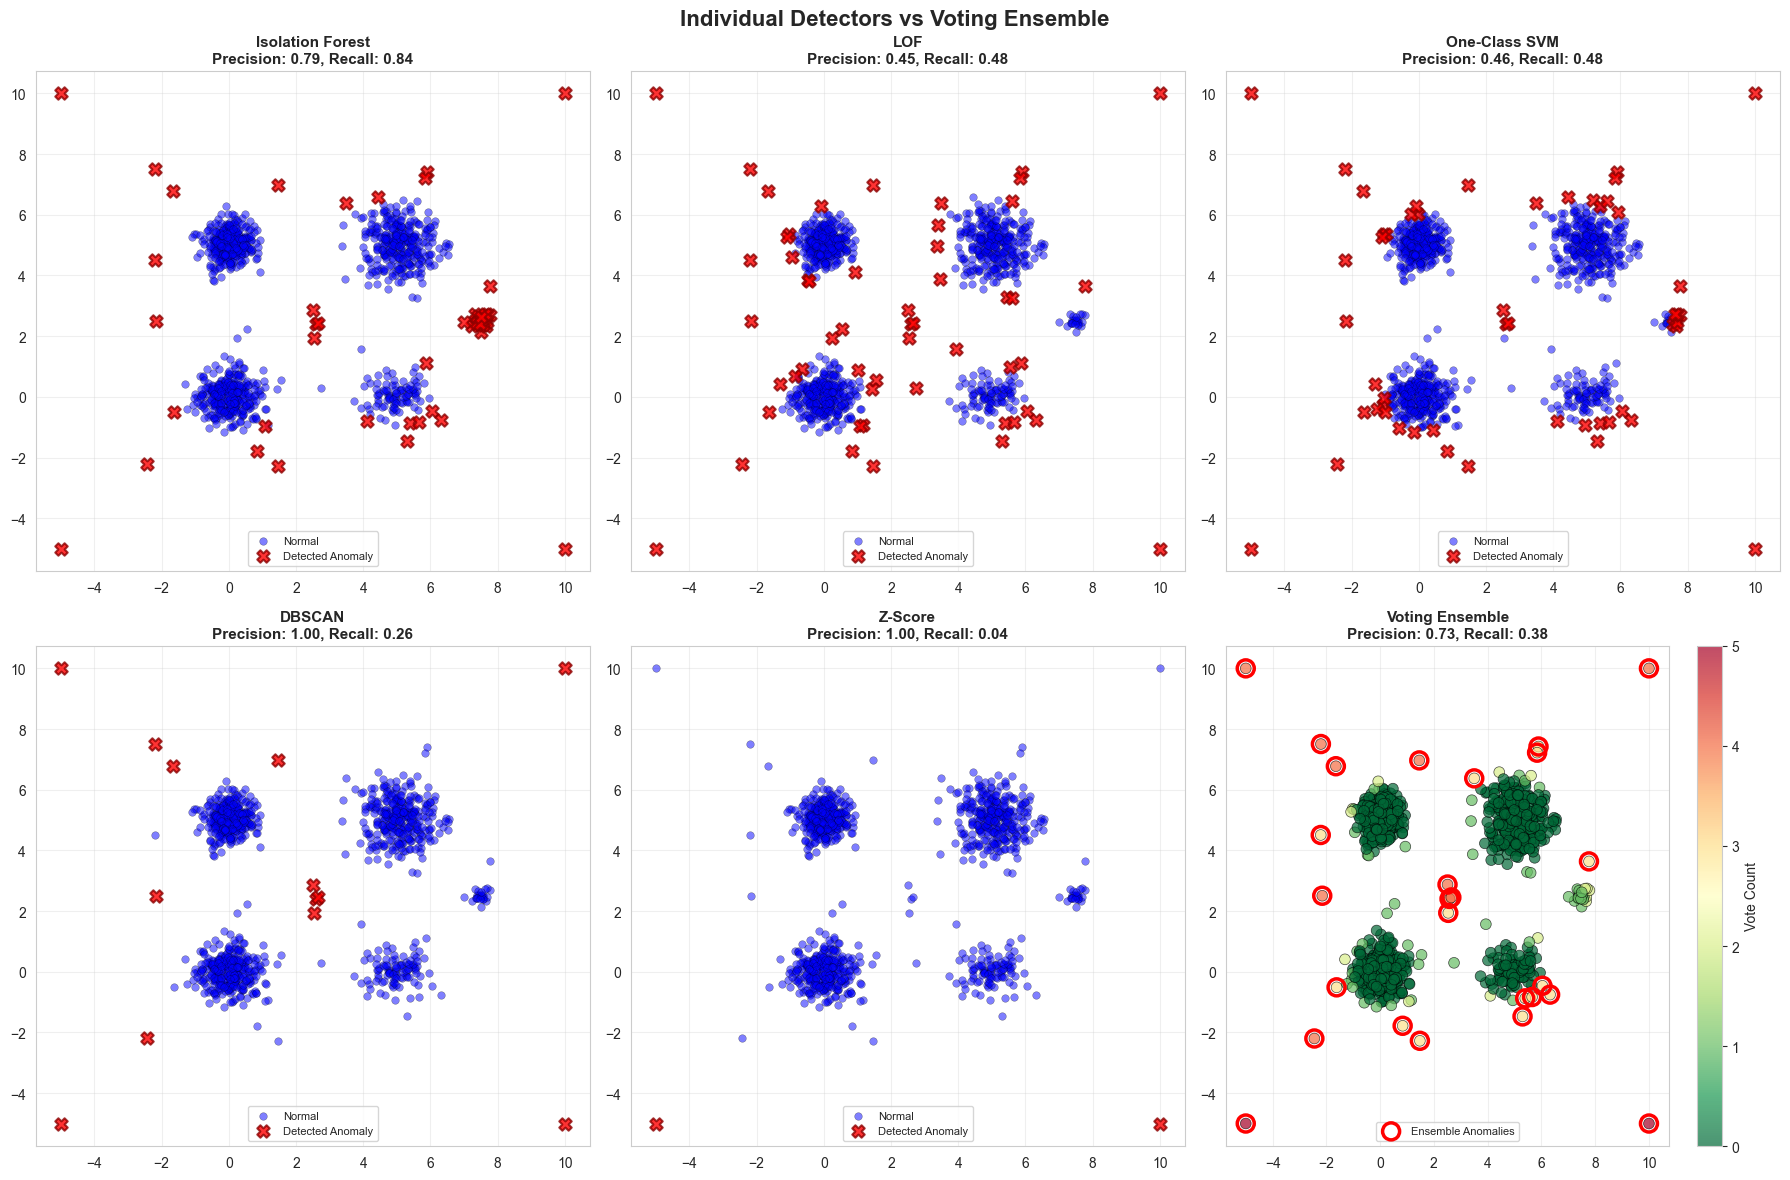

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Individual detectors
detectors = [
    (iso_predictions, "Isolation Forest"),
    (lof_predictions, "LOF"),
    (ocsvm_predictions, "One-Class SVM"),
    (dbscan_predictions, "DBSCAN"),
    (z_predictions, "Z-Score")
]

for idx, (pred, name) in enumerate(detectors):
    ax = axes[idx // 3, idx % 3]

    # Plot normal points
    ax.scatter(X[pred == 0, 0], X[pred == 0, 1],
              c='blue', s=30, alpha=0.5, label='Normal', edgecolors='k', linewidths=0.3)

    # Plot detected anomalies
    ax.scatter(X[pred == 1, 0], X[pred == 1, 1],
              c='red', s=80, alpha=0.8, marker='X', label='Detected Anomaly',
              edgecolors='darkred', linewidths=1.5)

    # Calculate metrics
    precision = np.sum((pred == 1) & (y_true == 1)) / max(sum(pred), 1)
    recall = np.sum((pred == 1) & (y_true == 1)) / sum(y_true)

    ax.set_title(f'{name}\nPrecision: {precision:.2f}, Recall: {recall:.2f}',
                fontweight='bold', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Voting ensemble result
ax = axes[1, 2]

# Create color map based on vote counts
scatter = ax.scatter(X[:, 0], X[:, 1], c=vote_counts, cmap='RdYlGn_r',
                    s=60, alpha=0.7, edgecolors='k', linewidths=0.5)

# Highlight final predictions
ax.scatter(X[voting_pred == 1, 0], X[voting_pred == 1, 1],
          facecolors='none', edgecolors='red', s=150, linewidths=2.5,
          label='Ensemble Anomalies')

precision_ens = np.sum((voting_pred == 1) & (y_true == 1)) / max(sum(voting_pred), 1)
recall_ens = np.sum((voting_pred == 1) & (y_true == 1)) / sum(y_true)

ax.set_title(f'Voting Ensemble\nPrecision: {precision_ens:.2f}, Recall: {recall_ens:.2f}',
            fontweight='bold', fontsize=11)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Vote Count')

plt.suptitle('Individual Detectors vs Voting Ensemble', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Ensemble Strategy 2: Weighted Voting

Give more weight to better-performing detectors.

In [9]:
def weighted_voting_ensemble(predictions_list, scores_list, y_true_train):
    """
    Weighted voting based on detector performance

    Parameters:
    predictions_list: list of prediction arrays
    scores_list: list of anomaly score arrays
    y_true_train: true labels for weight calculation

    Returns:
    final predictions, weights
    """
    from sklearn.metrics import f1_score

    # Calculate weights based on F1 score
    weights = []
    for pred in predictions_list:
        f1 = f1_score(y_true_train, pred)
        weights.append(max(f1, 0.1))  # Minimum weight of 0.1

    weights = np.array(weights)
    weights = weights / np.sum(weights)  # Normalize

    # Weighted voting
    votes = np.column_stack(predictions_list)
    weighted_votes = np.sum(votes * weights, axis=1)

    # Predict based on weighted threshold
    final_predictions = (weighted_votes >= 0.5).astype(int)

    return final_predictions, weights, weighted_votes

# Apply weighted voting
scores_list = [iso_scores, lof_scores, ocsvm_scores, dbscan_scores, z_score_anomaly]

weighted_pred, weights, weighted_votes = weighted_voting_ensemble(
    predictions_list, scores_list, y_true
)

print("\n" + "="*60)
print("WEIGHTED VOTING ENSEMBLE RESULTS")
print("="*60)

detector_names = ['Isolation Forest', 'LOF', 'One-Class SVM', 'DBSCAN', 'Z-Score']
for name, weight in zip(detector_names, weights):
    print(f"{name:20s}: {weight:.3f}")

print(f"\nDetected anomalies: {sum(weighted_pred)}")
print(f"\nPerformance Metrics:")
print(classification_report(y_true, weighted_pred, target_names=['Normal', 'Anomaly']))


WEIGHTED VOTING ENSEMBLE RESULTS
Isolation Forest    : 0.360
LOF                 : 0.206
One-Class SVM       : 0.208
DBSCAN              : 0.182
Z-Score             : 0.044

Detected anomalies: 36

Performance Metrics:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98      1000
     Anomaly       0.69      0.50      0.58        50

    accuracy                           0.97      1050
   macro avg       0.83      0.74      0.78      1050
weighted avg       0.96      0.97      0.96      1050



## Ensemble Strategy 3: Average of Scores

Combine anomaly scores instead of binary predictions.

In [10]:
def average_scores_ensemble(scores_list, percentile_threshold=95):
    """
    Average anomaly scores from multiple detectors

    Parameters:
    scores_list: list of anomaly score arrays (higher = more anomalous)
    percentile_threshold: percentile for anomaly threshold

    Returns:
    final predictions, average scores
    """
    # Normalize each score to [0, 1]
    normalized_scores = []
    for scores in scores_list:
        min_score = np.min(scores)
        max_score = np.max(scores)
        if max_score > min_score:
            norm_score = (scores - min_score) / (max_score - min_score)
        else:
            norm_score = scores
        normalized_scores.append(norm_score)

    # Average normalized scores
    avg_scores = np.mean(normalized_scores, axis=0)

    # Set threshold
    threshold = np.percentile(avg_scores, percentile_threshold)
    final_predictions = (avg_scores > threshold).astype(int)

    return final_predictions, avg_scores, threshold

# Apply score averaging
avg_pred, avg_scores, threshold = average_scores_ensemble(scores_list, percentile_threshold=95)

print("\n" + "="*60)
print("AVERAGE SCORES ENSEMBLE RESULTS")
print("="*60)
print(f"Anomaly threshold: {threshold:.4f}")
print(f"Detected anomalies: {sum(avg_pred)}")
print(f"\nPerformance Metrics:")
print(classification_report(y_true, avg_pred, target_names=['Normal', 'Anomaly']))


AVERAGE SCORES ENSEMBLE RESULTS
Anomaly threshold: 0.2285
Detected anomalies: 53

Performance Metrics:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1000
     Anomaly       0.79      0.84      0.82        50

    accuracy                           0.98      1050
   macro avg       0.89      0.91      0.90      1050
weighted avg       0.98      0.98      0.98      1050



In [ ]:
### Visualize Score Distribution


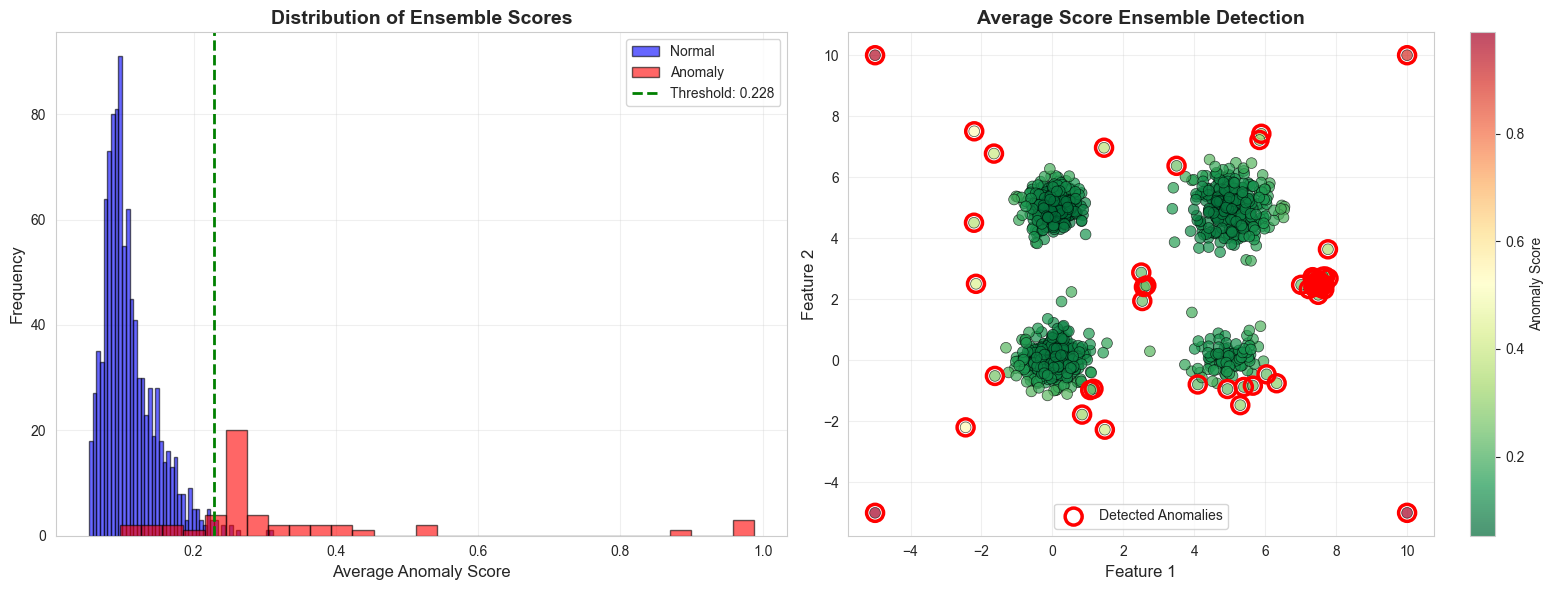

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Score distribution
ax1 = axes[0]
ax1.hist(avg_scores[y_true == 0], bins=50, alpha=0.6, label='Normal',
        color='blue', edgecolor='black')
ax1.hist(avg_scores[y_true == 1], bins=30, alpha=0.6, label='Anomaly',
        color='red', edgecolor='black')
ax1.axvline(threshold, color='green', linestyle='--', linewidth=2,
           label=f'Threshold: {threshold:.3f}')
ax1.set_xlabel('Average Anomaly Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Ensemble Scores', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter with scores
ax2 = axes[1]
scatter = ax2.scatter(X[:, 0], X[:, 1], c=avg_scores, cmap='RdYlGn_r',
                     s=60, alpha=0.7, edgecolors='k', linewidths=0.5)
ax2.scatter(X[avg_pred == 1, 0], X[avg_pred == 1, 1],
           facecolors='none', edgecolors='red', s=150, linewidths=2.5,
           label='Detected Anomalies')
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.set_title('Average Score Ensemble Detection', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Anomaly Score')

plt.tight_layout()
plt.show()


## Ensemble Strategy 4: Maximum Score

Use the maximum anomaly score from any detector.

In [12]:
def max_scores_ensemble(scores_list, percentile_threshold=95):
    """
    Take maximum anomaly score across all detectors
    """
    # Normalize scores
    normalized_scores = []
    for scores in scores_list:
        min_score = np.min(scores)
        max_score = np.max(scores)
        if max_score > min_score:
            norm_score = (scores - min_score) / (max_score - min_score)
        else:
            norm_score = scores
        normalized_scores.append(norm_score)

    # Take maximum
    max_scores = np.max(normalized_scores, axis=0)

    # Threshold
    threshold = np.percentile(max_scores, percentile_threshold)
    final_predictions = (max_scores > threshold).astype(int)

    return final_predictions, max_scores

# Apply max score ensemble
max_pred, max_scores_values = max_scores_ensemble(scores_list, percentile_threshold=95)

print("\n" + "="*60)
print("MAXIMUM SCORE ENSEMBLE RESULTS")
print("="*60)
print(f"Detected anomalies: {sum(max_pred)}")
print(f"\nPerformance Metrics:")
print(classification_report(y_true, max_pred, target_names=['Normal', 'Anomaly']))


MAXIMUM SCORE ENSEMBLE RESULTS
Detected anomalies: 53

Performance Metrics:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1000
     Anomaly       0.79      0.84      0.82        50

    accuracy                           0.98      1050
   macro avg       0.89      0.91      0.90      1050
weighted avg       0.98      0.98      0.98      1050



## Ensemble Strategy 5: Stacking with Meta-Learner

Use a meta-model to learn the best combination of detectors.

In [13]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def stacking_ensemble(predictions_list, scores_list, y_true, test_size=0.3):
    """
    Stacking ensemble with meta-learner

    Parameters:
    predictions_list: list of base predictions
    scores_list: list of anomaly scores
    y_true: true labels
    test_size: fraction for meta-model training

    Returns:
    final predictions on full dataset
    """
    # Create feature matrix from scores
    X_meta = np.column_stack(scores_list)

    # Split for meta-model training
    X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(
        X_meta, y_true, test_size=test_size, random_state=42, stratify=y_true
    )

    # Train meta-learner
    meta_model = LogisticRegression(random_state=42, max_iter=1000)
    meta_model.fit(X_train_meta, y_train_meta)

    # Predict on full dataset
    final_predictions = meta_model.predict(X_meta)
    prediction_proba = meta_model.predict_proba(X_meta)[:, 1]

    # Evaluate on test set
    test_predictions = meta_model.predict(X_test_meta)

    return final_predictions, prediction_proba, meta_model, test_predictions, y_test_meta

# Apply stacking
stacking_pred, stacking_proba, meta_model, test_pred, y_test = stacking_ensemble(
    predictions_list, scores_list, y_true
)

print("\n" + "="*60)
print("STACKING ENSEMBLE RESULTS (with Logistic Regression)")
print("="*60)

# Feature importance (weights from logistic regression)
print("\nMeta-Model Coefficients:")
for name, coef in zip(detector_names, meta_model.coef_[0]):
    print(f"{name:20s}: {coef:7.3f}")

print(f"\nDetected anomalies: {sum(stacking_pred)}")
print(f"\nPerformance Metrics (Full Dataset):")
print(classification_report(y_true, stacking_pred, target_names=['Normal', 'Anomaly']))

print(f"\nTest Set Performance:")
print(classification_report(y_test, test_pred, target_names=['Normal', 'Anomaly']))


STACKING ENSEMBLE RESULTS (with Logistic Regression)

Meta-Model Coefficients:
Isolation Forest    :   1.659
LOF                 :   1.778
One-Class SVM       :   0.387
DBSCAN              :   1.845
Z-Score             :   3.034

Detected anomalies: 17

Performance Metrics (Full Dataset):
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98      1000
     Anomaly       0.88      0.30      0.45        50

    accuracy                           0.96      1050
   macro avg       0.92      0.65      0.71      1050
weighted avg       0.96      0.96      0.96      1050


Test Set Performance:
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.99       300
     Anomaly       1.00      0.47      0.64        15

    accuracy                           0.97       315
   macro avg       0.99      0.73      0.81       315
weighted avg       0.98      0.97      0.97       315



## Comprehensive Comparison

Compare all ensemble strategies:

In [14]:
ensemble_results = {
    'Voting (Majority)': voting_pred,
    'Weighted Voting': weighted_pred,
    'Average Scores': avg_pred,
    'Max Scores': max_pred,
    'Stacking': stacking_pred
}

# Calculate metrics for each
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

comparison_data = []

for method_name, predictions in ensemble_results.items():
    comparison_data.append({
        'Method': method_name,
        'Precision': precision_score(y_true, predictions),
        'Recall': recall_score(y_true, predictions),
        'F1-Score': f1_score(y_true, predictions),
        'MCC': matthews_corrcoef(y_true, predictions),
        'Detected': sum(predictions)
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("ENSEMBLE METHODS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Find best method
best_method_idx = comparison_df['F1-Score'].idxmax()
best_method = comparison_df.loc[best_method_idx, 'Method']
best_f1 = comparison_df.loc[best_method_idx, 'F1-Score']

print(f"\nBest performing method: {best_method} (F1-Score: {best_f1:.3f})")


ENSEMBLE METHODS COMPARISON
           Method  Precision  Recall  F1-Score      MCC  Detected
Voting (Majority)   0.730769    0.38  0.500000 0.511160        26
  Weighted Voting   0.694444    0.50  0.581395 0.572300        36
   Average Scores   0.792453    0.84  0.815534 0.806406        53
       Max Scores   0.792453    0.84  0.815534 0.806406        53
         Stacking   0.882353    0.30  0.447761 0.502836        17

Best performing method: Average Scores (F1-Score: 0.816)


### Visualize Comparison


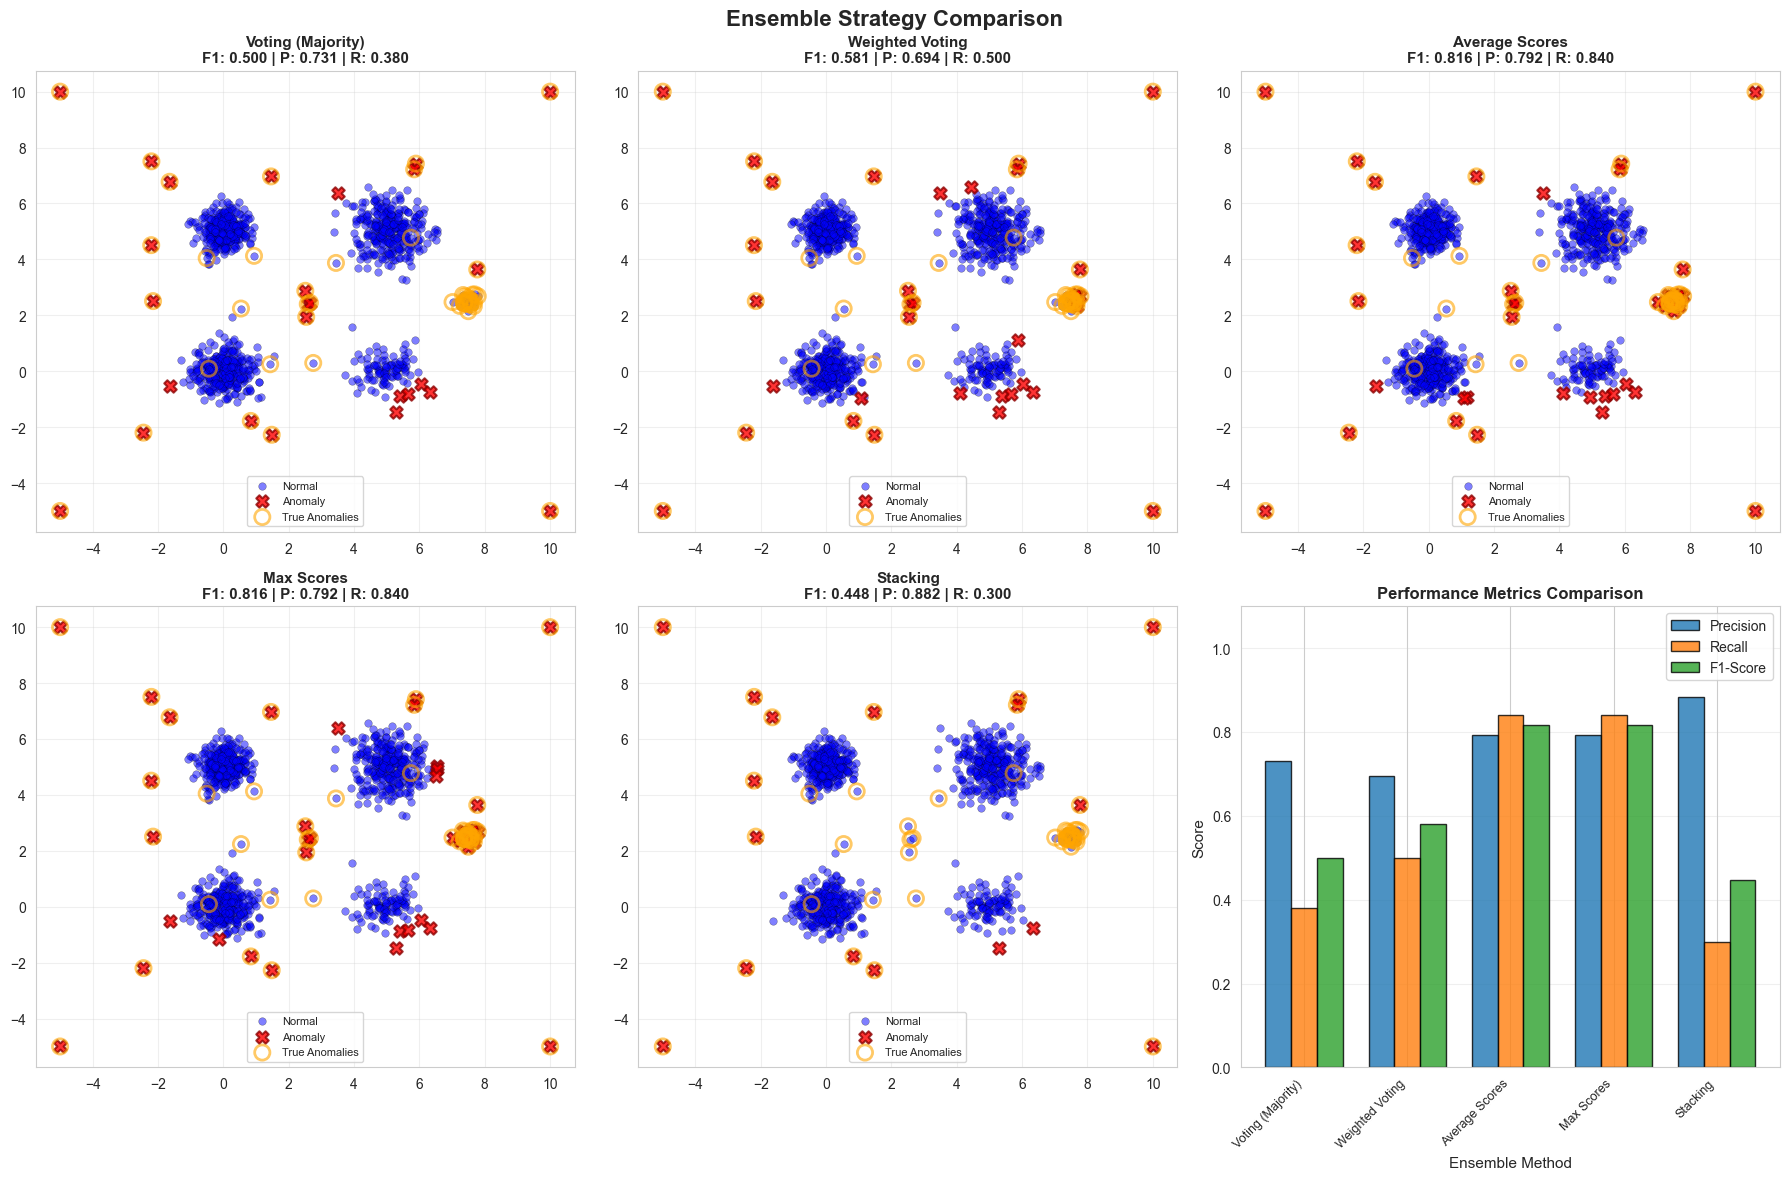

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

methods = list(ensemble_results.keys())

for idx, (method_name, predictions) in enumerate(ensemble_results.items()):
    ax = axes[idx // 3, idx % 3]

    # Plot results
    ax.scatter(X[predictions == 0, 0], X[predictions == 0, 1],
              c='blue', s=30, alpha=0.5, label='Normal', edgecolors='k', linewidths=0.3)
    ax.scatter(X[predictions == 1, 0], X[predictions == 1, 1],
              c='red', s=80, alpha=0.8, marker='X', label='Anomaly',
              edgecolors='darkred', linewidths=1.5)

    # Add true anomalies as reference
    ax.scatter(X[y_true == 1, 0], X[y_true == 1, 1],
              facecolors='none', edgecolors='orange', s=120, linewidths=2,
              label='True Anomalies', alpha=0.6)

    # Metrics
    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)
    f1 = f1_score(y_true, predictions)

    ax.set_title(f'{method_name}\nF1: {f1:.3f} | P: {precision:.3f} | R: {recall:.3f}',
                fontweight='bold', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Last subplot: Metrics comparison bar chart
ax = axes[1, 2]
x_pos = np.arange(len(comparison_df))
width = 0.25

bars1 = ax.bar(x_pos - width, comparison_df['Precision'], width,
              label='Precision', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x_pos, comparison_df['Recall'], width,
              label='Recall', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x_pos + width, comparison_df['F1-Score'], width,
              label='F1-Score', alpha=0.8, edgecolor='black')

ax.set_xlabel('Ensemble Method', fontsize=11)
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Performance Metrics Comparison', fontweight='bold', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Method'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.suptitle('Ensemble Strategy Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## ROC Curves for All Ensembles


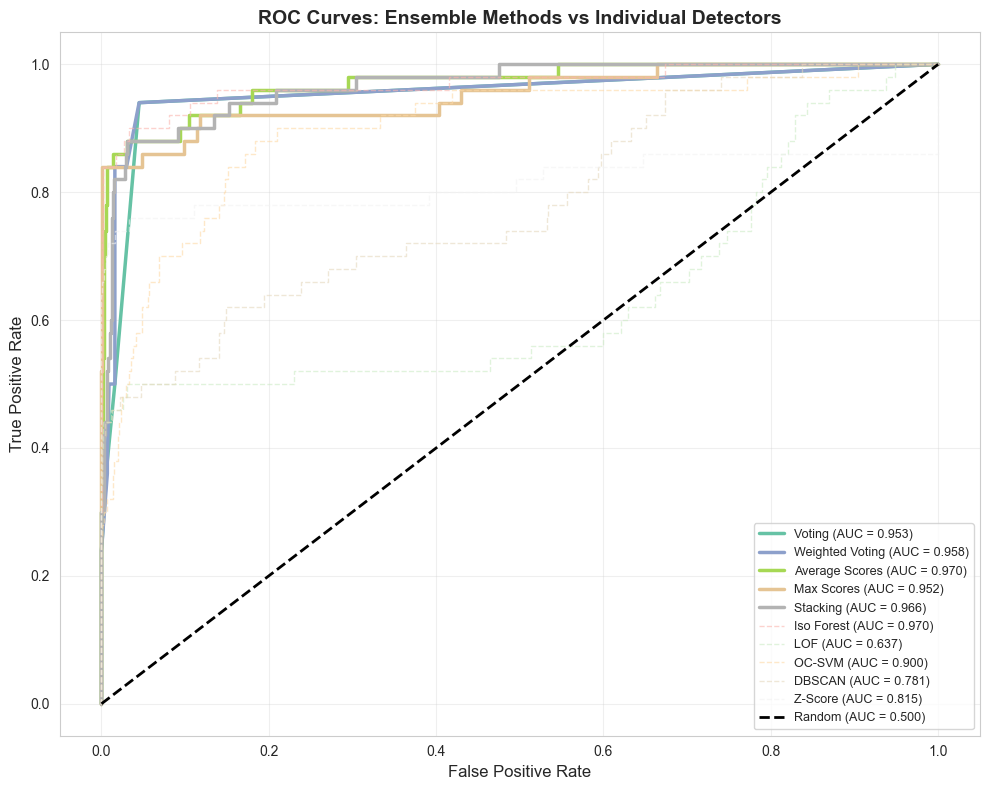

In [16]:

fig, ax = plt.subplots(figsize=(10, 8))

# Calculate ROC for each method
ensemble_scores_dict = {
    'Voting': vote_counts / len(predictions_list),
    'Weighted Voting': weighted_votes,
    'Average Scores': avg_scores,
    'Max Scores': max_scores_values,
    'Stacking': stacking_proba
}

colors = plt.cm.Set2(np.linspace(0, 1, len(ensemble_scores_dict)))

for (method_name, scores), color in zip(ensemble_scores_dict.items(), colors):
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=color, linewidth=2.5,
           label=f'{method_name} (AUC = {roc_auc:.3f})')

# Add individual detectors for reference
individual_colors = plt.cm.Pastel1(np.linspace(0, 1, 5))
for (name, scores), color in zip([('Iso Forest', iso_scores),
                                  ('LOF', lof_scores),
                                  ('OC-SVM', ocsvm_scores),
                                  ('DBSCAN', dbscan_scores),
                                  ('Z-Score', z_score_anomaly)], individual_colors):
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linewidth=1, linestyle='--', alpha=0.6,
           label=f'{name} (AUC = {roc_auc:.3f})')

# Random classifier
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.500)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Ensemble Methods vs Individual Detectors',
            fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()